In [5]:
import numpy as np

class LogisticRegression:
    def __init__(self, lr=0.1, num_iter=10000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    def __sigmoid(self, z):
        # Prevent overflow problem
        h = np.zeros(len(z))
        for i in range(len(z)):
            if z[i]<0: 
                h[i] = np.exp(z[i]) / (1 + np.exp(z[i]))
            else: 
                h[i] = 1 / (1 + np.exp(-z[i]))
        return h
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __loss(self, h, y, eps=1e-15):
        # clip predicted probability to avoid taking the logarithm of 0
        h = np.clip(h, eps, 1 - eps)
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            if self.verbose and i % 1000 == 0:
                z = np.dot(X, self.theta)
                h = self.__sigmoid(z)
                print(f'Loss: {self.__loss(h, y)} \t')
    
    def predict_proba(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

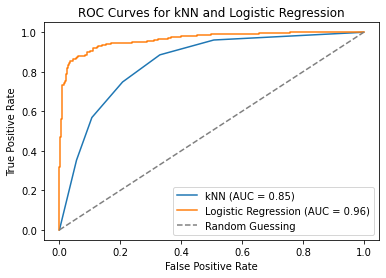

In [8]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('data/emails.csv')
X_train = data.iloc[:4000, 1:-1]
y_train = data.iloc[:4000, -1]
X_test = data.iloc[4000:, 1:-1]
y_test = data.iloc[4000:, -1]

# Train kNN with k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Train logistic regression
lr = LogisticRegression(lr=0.01)
lr.fit(X_train, y_train)

# Calculate predicted probabilities for kNN and logistic regression
y_hat_knn = knn.predict_proba(X_test)[:, 1]
y_hat_lr = lr.predict_proba(X_test)

# Calculate the false positive rate, true positive rate, and threshold for kNN and logistic regression
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, y_hat_knn)
logreg_fpr, logreg_tpr, logreg_thresholds = roc_curve(y_test, y_hat_lr)

# Calculate the AUC (area under the curve) for kNN and logistic regression
knn_auc = roc_auc_score(y_test, y_hat_knn)
logreg_auc = roc_auc_score(y_test, y_hat_lr)

# Plot the ROC curves
plt.plot(knn_fpr, knn_tpr, label='kNN (AUC = {:.2f})'.format(knn_auc))
plt.plot(logreg_fpr, logreg_tpr, label='Logistic Regression (AUC = {:.2f})'.format(logreg_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for kNN and Logistic Regression')
plt.legend()
plt.show()